# Bibliotecas

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import friedmanchisquare

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neural_network import MLPClassifier

from six import StringIO
from IPython.display import Image  
import pydotplus

Mounted at /content/drive


# Pré-processamento


In [ ]:
X = pd.read_csv("drive/My Drive/UNIOESTE/Quarto ano/IA/Projeto 3/Database/breast_cancer_wisconsin.csv")
X = X.drop(['id', 'Unnamed: 32'], axis = 1)
X.loc[X['diagnosis'] == 'M', 'diagnosis'] = 0
X.loc[X['diagnosis'] == 'B', 'diagnosis'] = 1
X['diagnosis'] = X['diagnosis'].astype(int)

# #############################################
# # Resample
# c0 = X[X['diagnosis'] == 0]
# c1 = X[X['diagnosis'] == 1]
# c1 =  c1.sample(212)
# X = pd.concat([c1,c0],axis=0)
# #############################################

y = X.pop('diagnosis')

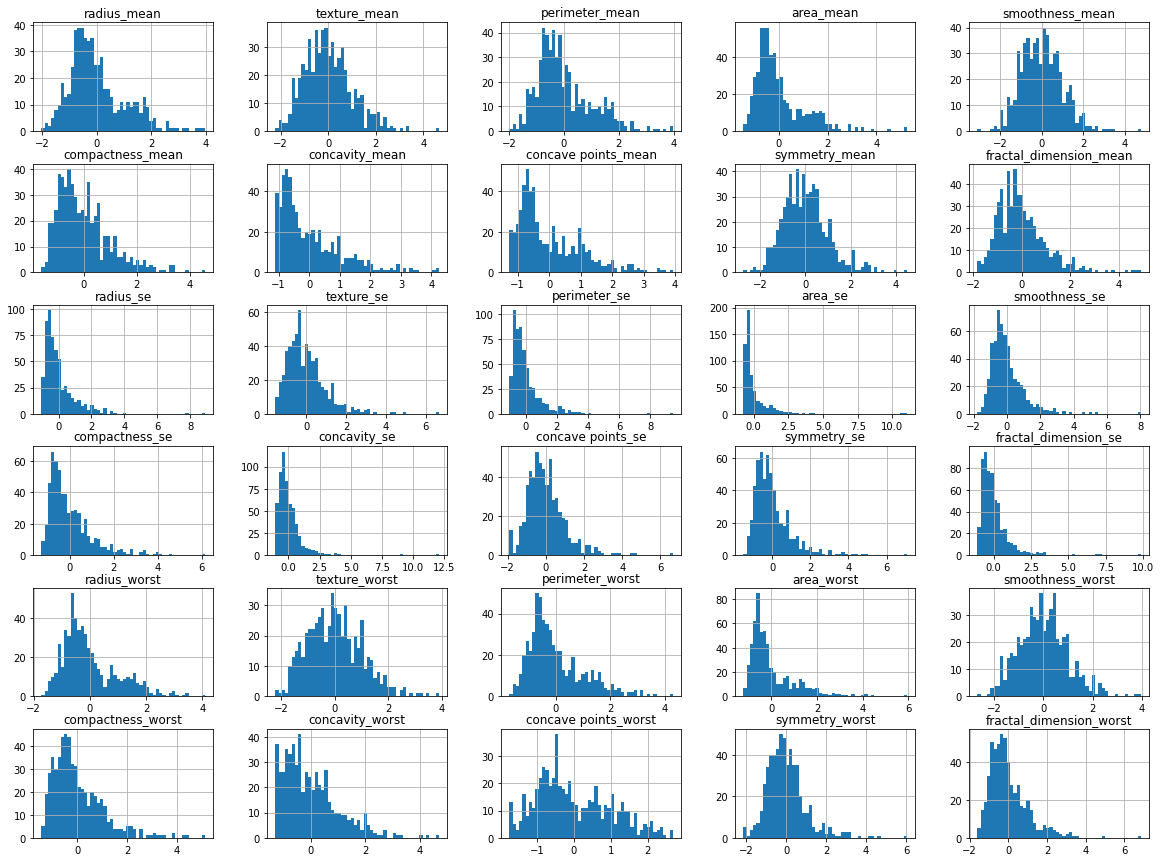

In [ ]:
def std_scaler(X):
  dataset = X.copy(deep = True)
  x = dataset.values
  cols = list(dataset.columns.values)
  min_max_scaler = StandardScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  data = pd.DataFrame(x_scaled, columns = cols)
  return data

X = std_scaler(X)
X.hist(bins=50, figsize=(20,15))
plt.show()

**Seleção de atributos**

In [ ]:
feature_names = cols = list(X.columns.values)
knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(knn, n_features_to_select=10, direction='forward').fit(X, y)
sfs.get_feature_names_out()
X = X[sfs.get_feature_names_out()].copy(deep = True)

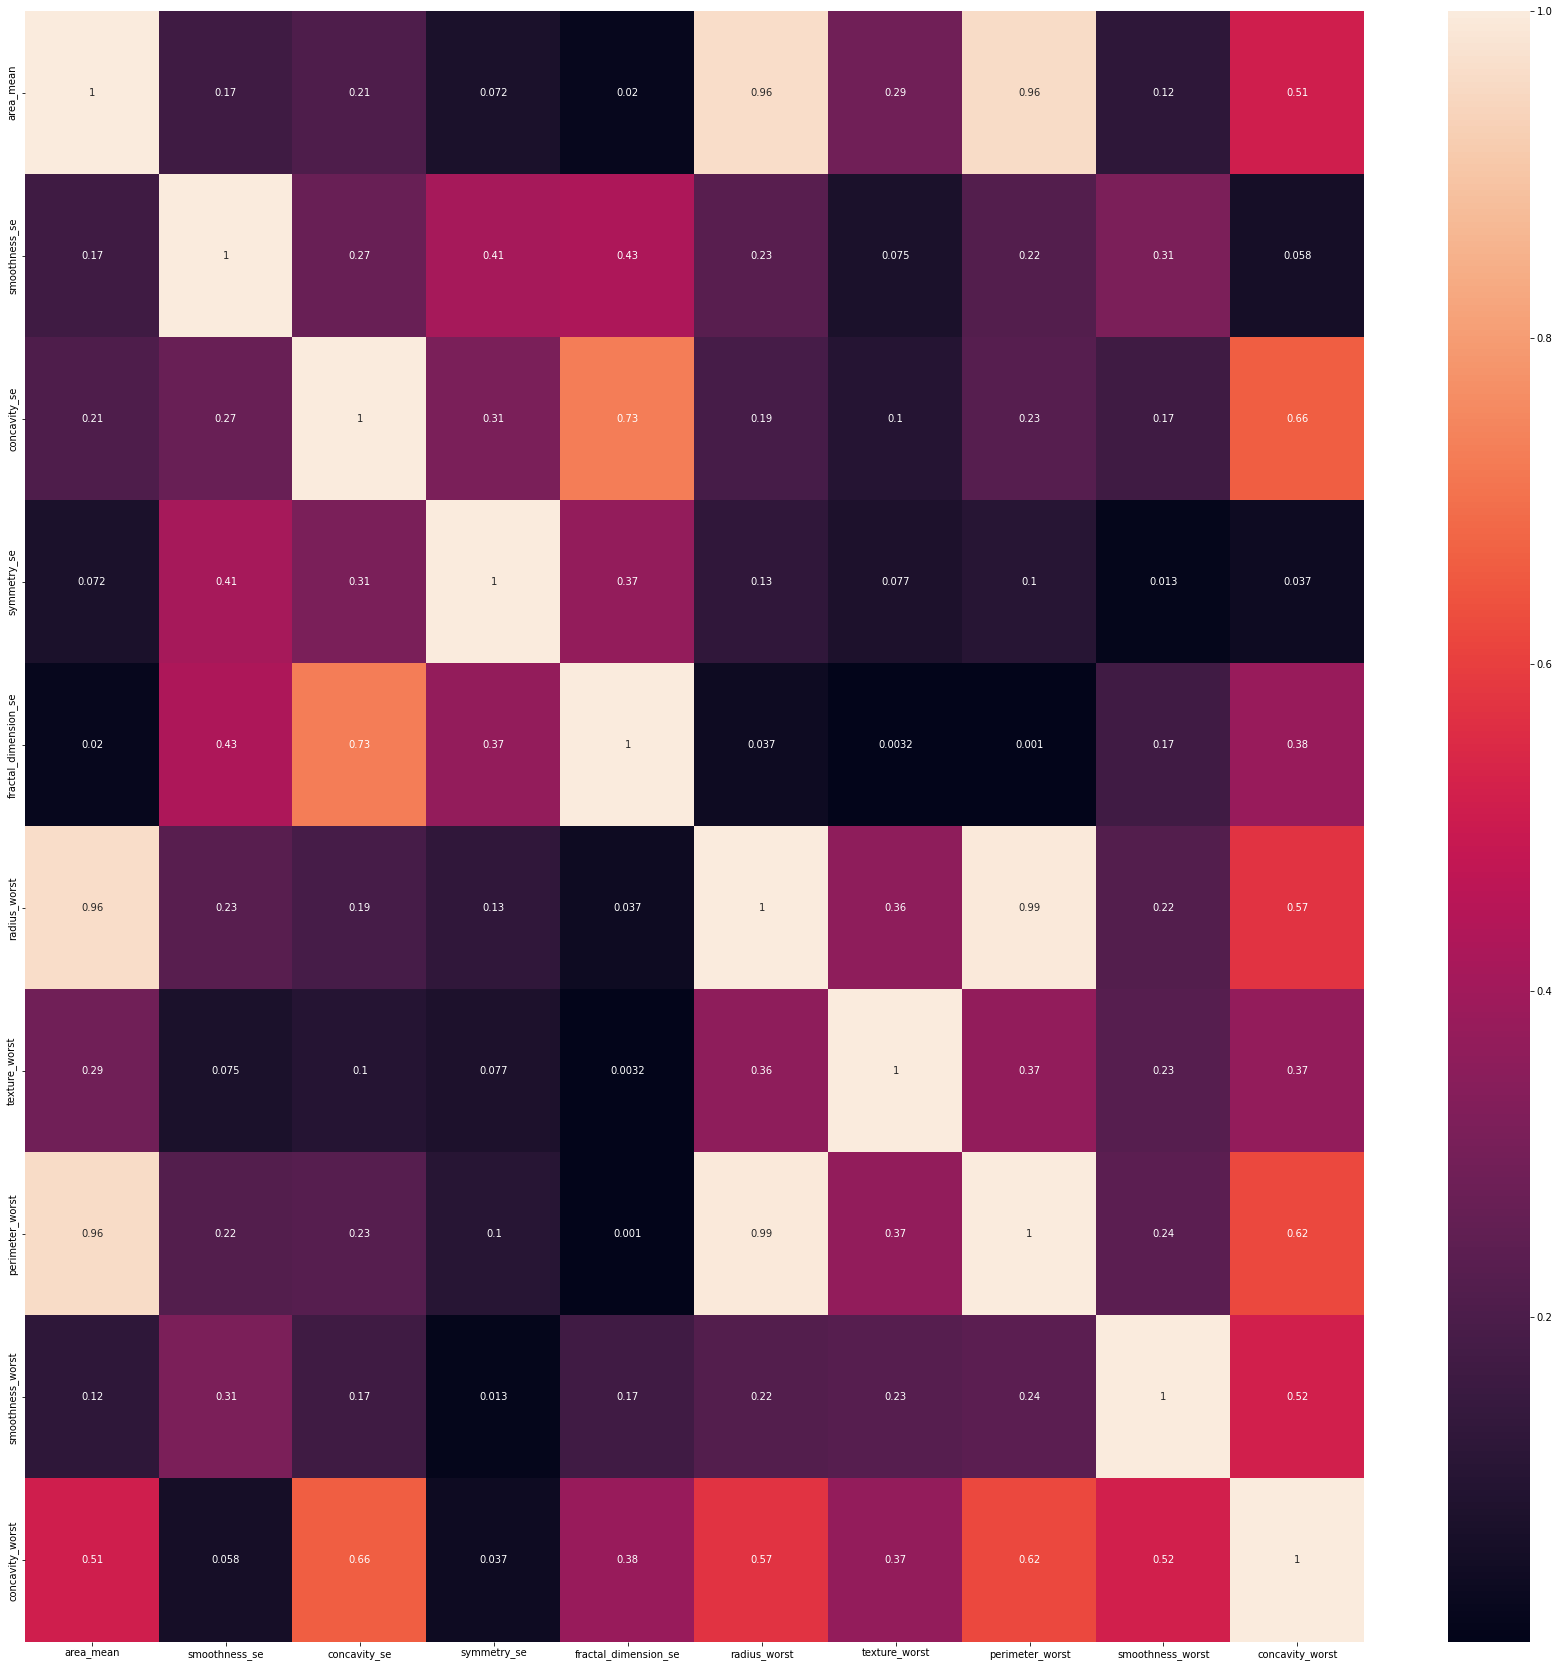

In [ ]:
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(X.corr(method='pearson', min_periods=1).abs(), annot=True)

Definindo correlação forte como igual ou maior a 90%.

Correlação forte com *smoothness_mean*:
1. *radius_worst*;
2. *perimeter_worst*.

**Número tributos fortemente correlacionados removidos: 2**

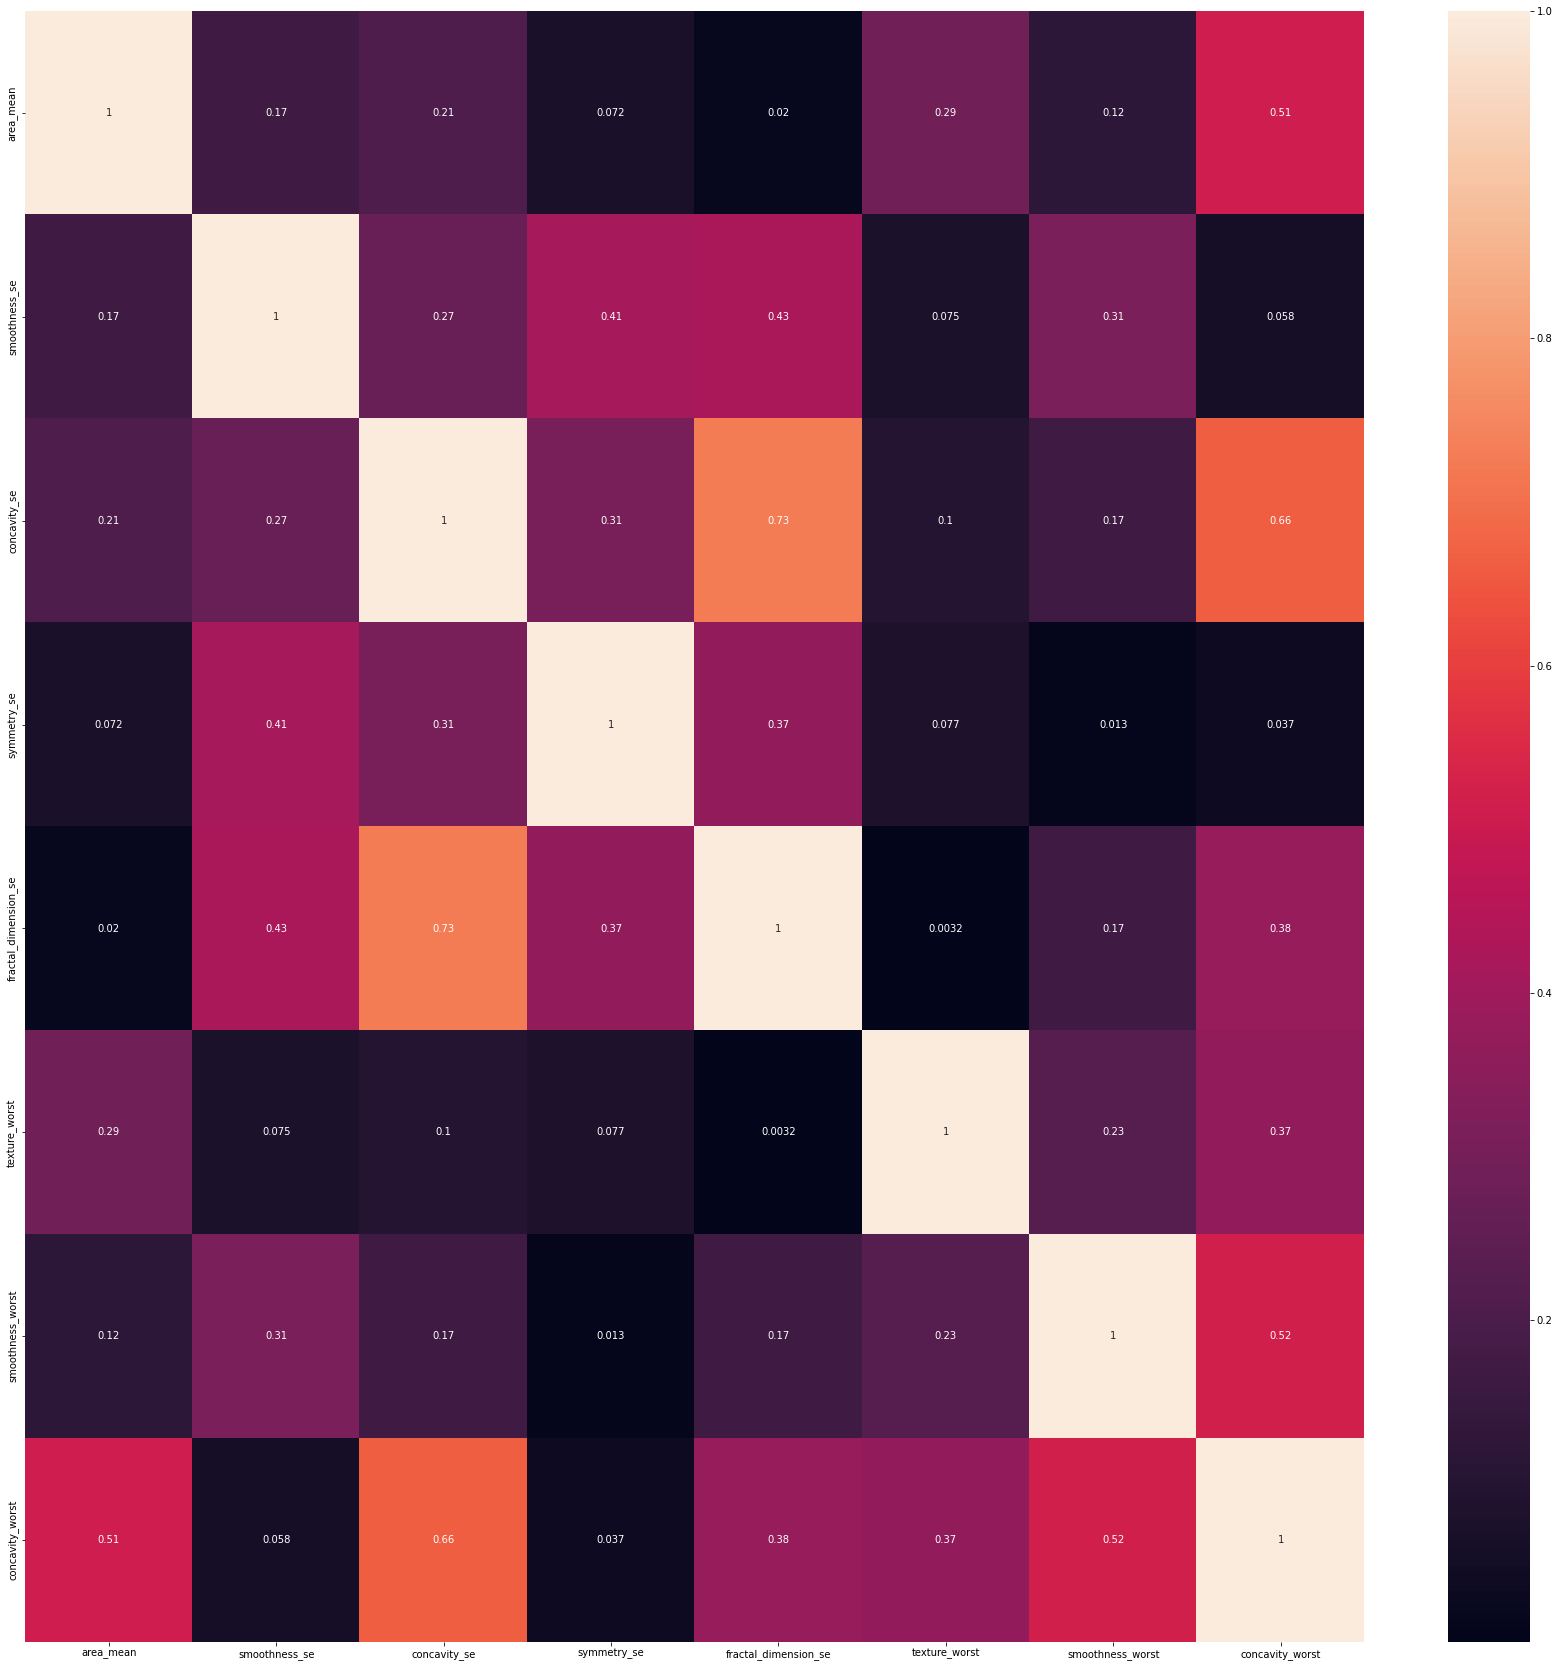

In [ ]:
X = X.drop(['radius_worst',
            'perimeter_worst'], axis=1)


fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(X.corr(method='pearson', min_periods=1).abs(), annot=True)

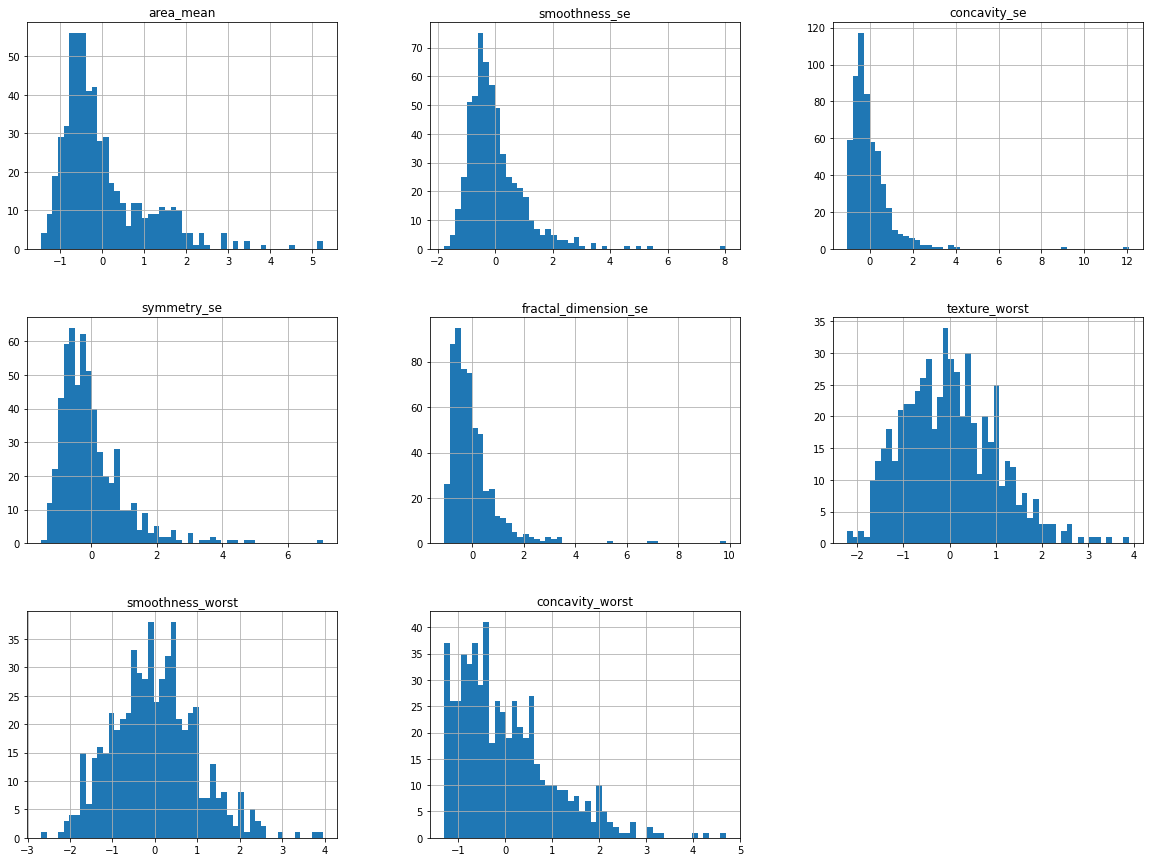

In [ ]:
X.hist(bins=50, figsize=(20,15))
plt.show()

# Extração de padrões

## *5-nearest neighbors classifier* (KNN)

### Funções de apoio

In [ ]:
def knn_stratified_holdout(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

  clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto',
                             leaf_size=30, p=2, metric='minkowski',
                             metric_params=None, n_jobs=None)
  clf.fit(X_train, y_train)

  pred = clf.predict(X_test)
  print(metrics.classification_report(y_test, pred))
  confusion_matrix = metrics.confusion_matrix(y_test, pred)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
  fig, ax = plt.subplots(figsize=(7,7))
  cm_display.plot(ax=ax)
  plt.show()

def knn_stratified_cross_validation(X, y, k):
  clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto',
                             leaf_size=30, p=2, metric='minkowski',
                             metric_params=None, n_jobs=None)

  metrics_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
  results = cross_validate(clf, X, y, cv=k, scoring=metrics_list)

  report = [results['test_recall_macro'], [((np.mean(results['test_recall_macro']))*100), (np.std(results['test_recall_macro'])*100)]]
  
  for r in results:
    if r != 'fit_time' and r != 'score_time':
      print(f"{r}: {(results[r])*100}")
      print(f"AVG: {(np.mean(results[r]))*100} +- {(np.std(results[r]))*100}\n")
    else:
      print(f"{r}: {results[r]}")
      print(f"AVG: {np.mean(results[r])} +- {np.std(results[r])}\n")
  return report

### *Stratified holdout* (KNN)

              precision    recall  f1-score   support

           0       0.91      0.90      0.91        70
           1       0.94      0.95      0.95       118

    accuracy                           0.93       188
   macro avg       0.93      0.92      0.93       188
weighted avg       0.93      0.93      0.93       188



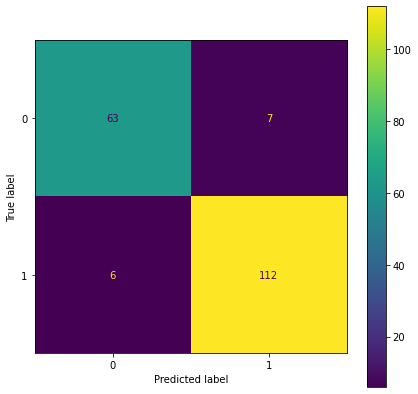

In [ ]:
knn_stratified_holdout(X, y)

### *Stratified 10-fold cross-validation* (KNN)

In [ ]:
knn_report = knn_stratified_cross_validation(X, y, 10)

fit_time: [0.006845   0.0022788  0.00223136 0.00220728 0.0031116  0.00324416
 0.00227928 0.00221801 0.00217628 0.00222921]
AVG: 0.002882099151611328 +- 0.0013733160708711428

score_time: [0.00776315 0.00612259 0.00755239 0.00598979 0.01365352 0.00612569
 0.00604725 0.00595284 0.00598717 0.00607777]
AVG: 0.007127213478088379 +- 0.0022678272578792696

test_accuracy: [92.98245614 89.47368421 96.49122807 94.73684211 98.24561404 94.73684211
 92.98245614 96.49122807 96.49122807 85.71428571]
AVG: 93.83458646616543 +- 3.587025696804982

test_precision_macro: [93.44594595 88.8961039  97.36842105 94.02597403 98.64864865 96.15384615
 93.42105263 96.23015873 97.36842105 84.58498024]
AVG: 94.01435523746736 +- 4.113979079872722

test_recall_macro: [91.75324675 88.8961039  95.23809524 94.84126984 97.61904762 92.85714286
 91.46825397 96.23015873 95.23809524 85.71428571]
AVG: 92.98556998556998 +- 3.4499348241058736

test_f1_macro: [92.46031746 88.8961039  96.14864865 94.39895185 98.0955563  94.15384615

## Árvore de Decisão (C4.5)

### Funções de apoio

In [ ]:
def c45_stratified_holdout(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

  clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5,
                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                               max_features=None, random_state=None, max_leaf_nodes=None,
                               min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
  clf.fit(X_train, y_train)

  pred = clf.predict(X_test)
  print(metrics.classification_report(y_test, pred))
  confusion_matrix = metrics.confusion_matrix(y_test, pred)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
  fig, ax = plt.subplots(figsize=(7,7))
  cm_display.plot(ax=ax)
  plt.show()

  return clf

def c45_stratified_cross_validation(X, y, k):
  clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5,
                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                               max_features=None, random_state=None, max_leaf_nodes=None,
                               min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)

  metrics_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
  results = cross_validate(clf, X, y, cv=k, scoring=metrics_list)
  
  report = [results['test_recall_macro'], [((np.mean(results['test_recall_macro']))*100), (np.std(results['test_recall_macro'])*100)]]

  for r in results:
    if r != 'fit_time' and r != 'score_time':
      print(f"{r}: {(results[r])*100}")
      print(f"AVG: {(np.mean(results[r]))*100} +- {(np.std(results[r]))*100}\n")
    else:
      print(f"{r}: {results[r]}")
      print(f"AVG: {np.mean(results[r])} +- {np.std(results[r])}\n")
  
  return report

### *Stratified holdout* (C4.5)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        70
           1       0.92      0.92      0.92       118

    accuracy                           0.90       188
   macro avg       0.90      0.90      0.90       188
weighted avg       0.90      0.90      0.90       188



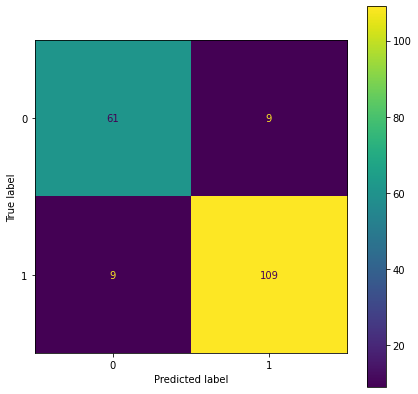

In [ ]:
clf = c45_stratified_holdout(X, y)

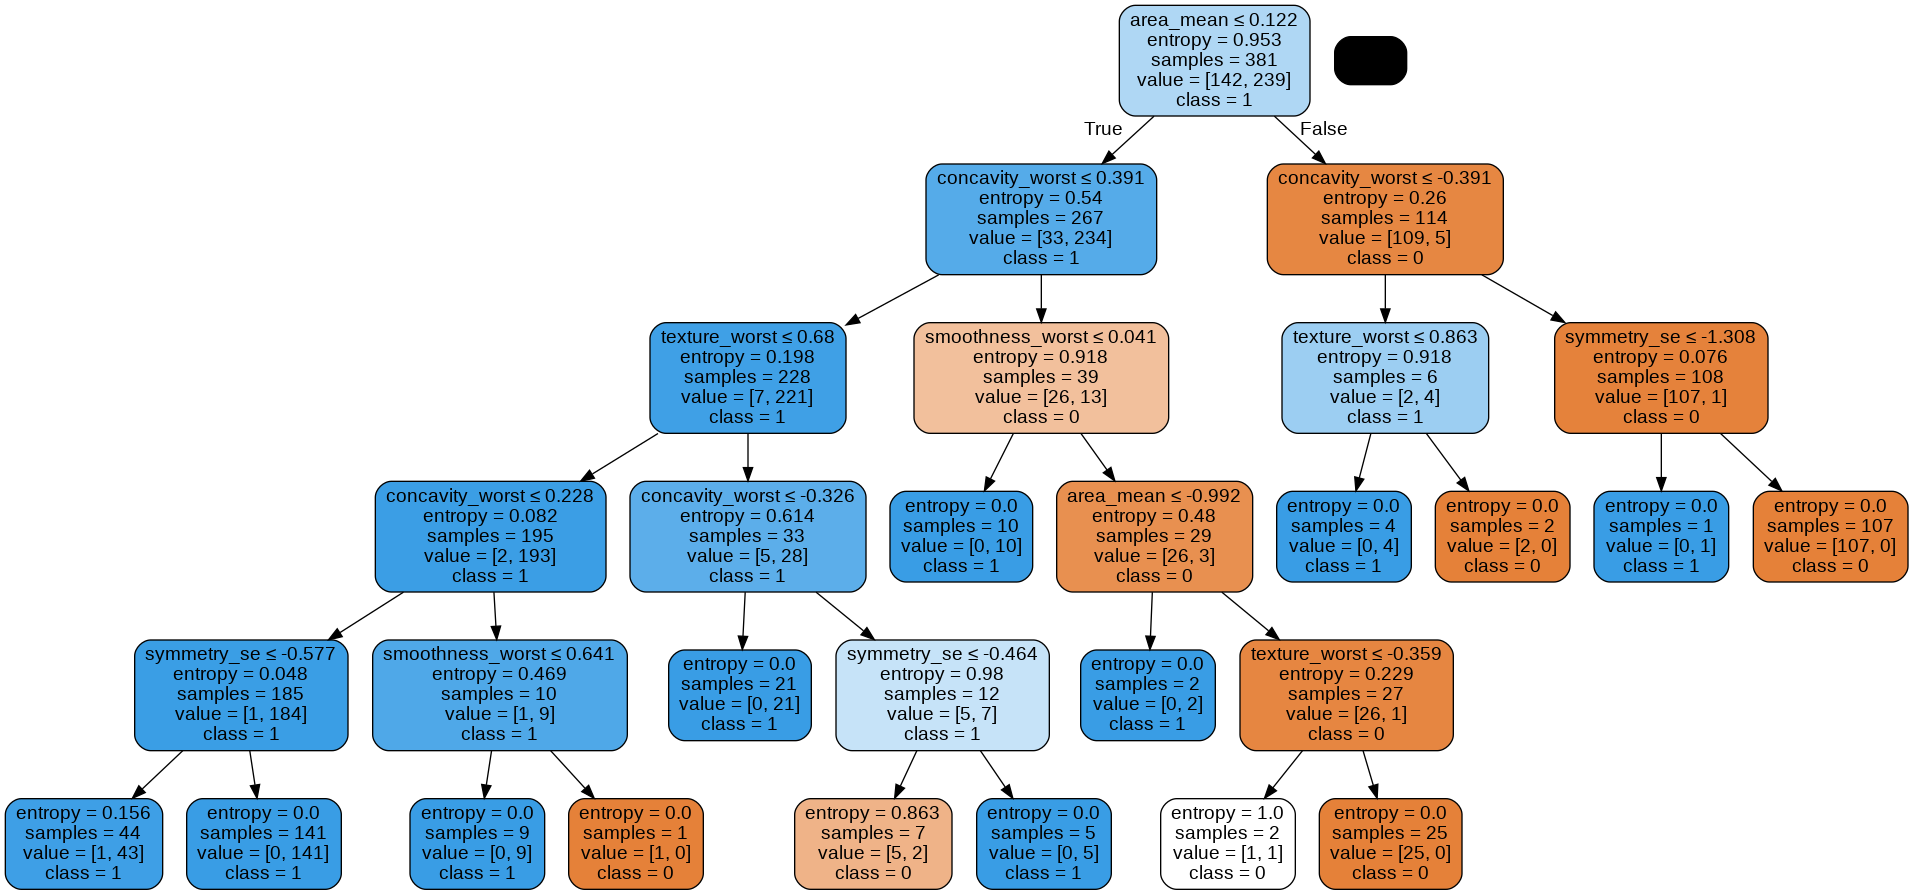

In [ ]:
# Representação visual da árvore de decisão com treino stratified holdout
feature_cols = list(X.columns.values)
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names = feature_cols, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('breast_cancer.png')
Image(graph.create_png())

### *Stratified 10-fold cross-validation* (C4.5)

In [ ]:
c45_report = c45_stratified_cross_validation(X, y, 10)

fit_time: [0.00973511 0.00649619 0.00882721 0.00614071 0.00734925 0.00852895
 0.00469446 0.00479364 0.00468874 0.00606203]
AVG: 0.006731629371643066 +- 0.0017307907451470479

score_time: [0.00655961 0.01237082 0.00517154 0.00479102 0.0118525  0.00472021
 0.00421596 0.00399089 0.0039885  0.00397205]
AVG: 0.006163311004638672 +- 0.0030667494269322323

test_accuracy: [94.73684211 87.71929825 96.49122807 87.71929825 98.24561404 96.49122807
 92.98245614 96.49122807 85.96491228 98.21428571]
AVG: 93.50563909774436 +- 4.438418220480987

test_precision_macro: [94.         87.3015873  95.65217391 87.09459459 98.64864865 96.23015873
 92.00767263 95.65217391 85.37037037 97.72727273]
AVG: 92.96846528329905 +- 4.541894485037268

test_recall_macro: [95.71428571 86.62337662 97.22222222 86.30952381 97.61904762 96.23015873
 93.45238095 97.22222222 87.8968254  98.57142857]
AVG: 93.68614718614717 +- 4.612969411026105

test_f1_macro: [94.56970467 86.93088765 96.2987013  86.66889409 98.0955563  96.23015873


## *Multilayer Perceptron* (MLP)

### Funções de apoio

In [ ]:
def mlp_stratified_holdout(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

  clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs',
                      alpha=0.0001, batch_size='auto', learning_rate='constant',
                      learning_rate_init=0.001, power_t=0.5, max_iter=200,
                      shuffle=True, random_state=None, tol=0.0001,
                      verbose=False, warm_start=False, momentum=0.9,
                      nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1,
                      beta_1=0.9, beta_2=0.999, epsilon=1e-08,
                      n_iter_no_change=10, max_fun=15000)

  clf.fit(X_train, y_train)

  pred = clf.predict(X_test)
  print(metrics.classification_report(y_test, pred))
  confusion_matrix = metrics.confusion_matrix(y_test, pred)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
  fig, ax = plt.subplots(figsize=(7,7))
  cm_display.plot(ax=ax)
  plt.show()

def mlp_stratified_cross_validation(X, y, k):
  clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs',
                      alpha=0.0001, batch_size='auto', learning_rate='constant',
                      learning_rate_init=0.001, power_t=0.5, max_iter=200,
                      shuffle=True, random_state=None, tol=0.0001,
                      verbose=False, warm_start=False, momentum=0.9,
                      nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1,
                      beta_1=0.9, beta_2=0.999, epsilon=1e-08,
                      n_iter_no_change=10, max_fun=15000)

  metrics_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
  results = cross_validate(clf, X, y, cv=k, scoring=metrics_list)

  report = [results['test_recall_macro'], [((np.mean(results['test_recall_macro']))*100), (np.std(results['test_recall_macro'])*100)]]
  
  for r in results:
    if r != 'fit_time' and r != 'score_time':
      print(f"{r}: {(results[r])*100}")
      print(f"AVG: {(np.mean(results[r]))*100} +- {(np.std(results[r]))*100}\n")
    else:
      print(f"{r}: {results[r]}")
      print(f"AVG: {np.mean(results[r])} +- {np.std(results[r])}\n")
  
  return report

### *Stratified holdout (MLP)*

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        70
           1       0.98      0.96      0.97       118

    accuracy                           0.96       188
   macro avg       0.96      0.96      0.96       188
weighted avg       0.96      0.96      0.96       188



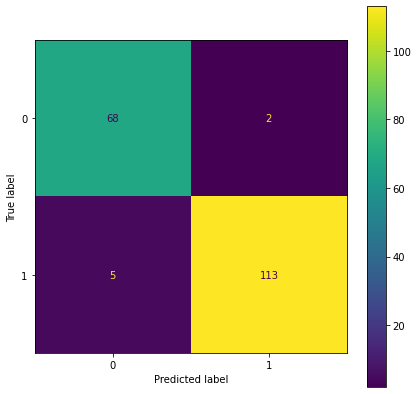

In [ ]:
mlp_stratified_holdout(X, y)

### *Stratified 10-fold cross-validation (MLP)*

In [ ]:
mlp_report = mlp_stratified_cross_validation(X, y, 10)

fit_time: [0.12818193 0.10900998 0.17030835 0.1223135  0.11140394 0.12220335
 0.10380745 0.11787915 0.14089489 0.11636996]
AVG: 0.12423725128173828 +- 0.01827479504225988

score_time: [0.00686216 0.00619578 0.00600004 0.006078   0.00598025 0.01080632
 0.005898   0.00597692 0.00592303 0.0058732 ]
AVG: 0.0065593719482421875 +- 0.0014419720088371976

test_accuracy: [98.24561404 96.49122807 98.24561404 98.24561404 96.49122807 96.49122807
 91.22807018 98.24561404 94.73684211 92.85714286]
AVG: 96.12781954887218 +- 2.344698261959533

test_precision_macro: [97.82608696 97.2972973  98.64864865 98.64864865 96.23015873 96.23015873
 90.32467532 97.72727273 94.02597403 92.38095238]
AVG: 95.93398734703082 +- 2.670162691986004

test_recall_macro: [98.57142857 95.45454545 97.61904762 97.61904762 96.23015873 96.23015873
 91.07142857 98.61111111 94.84126984 92.38095238]
AVG: 95.86291486291486 +- 2.4004019973626787

test_f1_macro: [98.16425121 96.23015873 98.0955563  98.0955563  96.23015873 96.23015873
 

# Pós-processamento


## Linha de raciocínio:

### 1. Verificar se os dados da sensibilidade de cada *fold* seguem uma distribuição normal;
### 2. Verificar se os grupos são pareados (em essência, se os algoritmos foram treinandos com os mesmos *folds*);
### 3. Verificar a quantidade de grupos que serão testados.


## 1. Teste de Normalidade (*Shapiro-Wilk*)

### Execução de teste Shapiro-Wilk tomando como condição para se rejeitar a hipótese nula (isto é, determinar que os dados **não seguem distribuição normal**) um p-valor < 0,05.

In [ ]:
knn_test = shapiro(knn_report[0])
c45_test = shapiro(c45_report[0])
mlp_test = shapiro(mlp_report[0])

print("KNN: " + str(knn_test))
print("C4.5: " + str(c45_test))
print("MLP: " + str(mlp_test))

KNN: ShapiroResult(statistic=0.9365959763526917, pvalue=0.5157943964004517)
C4.5: ShapiroResult(statistic=0.8107174038887024, pvalue=0.019562896341085434)
MLP: ShapiroResult(statistic=0.9055313467979431, pvalue=0.2516840398311615)


### Como o p-valor do grupo gerado pelo algoritmo C4.5 é menor que 0.05 **descarta-se os testes paramétricos** (mesmo que os outros dois apresentem uma distribuição normal).

## 2. Verificar se os grupos são pareados

### Pela documentação da função cross_validate da biblioteca scikit-learn é possível determinar que não há o embaralhamento dos *folds* durante o *cross-validation* de cada algoritmo. Ou seja: os algoritmos são treinados com os mesmos conjuntos de dados, desta forma **determina-se que os grupos são pareados**.

## 3. Verificar a quantidade de grupos que serão submetidos ao teste

### A quantidade de algoritmos de aprendizado de máquina executados é igual à três, gerando três grupos de desempenho (sensibilidade em cada *fold*) a serem comparados.

## Teste de *Friedman*

### Determinando que os dados não seguem distribuição normal, são pareados e são três grupos, escolhe-se o Teste de *Friedman* para o teste da existência de diferença estatisticamente significativa entre os três grupos. Determina-se a condição para rejeitar a hipótese nula (isto é, **haver diferença estatística significativa entre os grupos**) um p-valor < 0,05.

In [ ]:
friedmanchisquare(knn_report[0], c45_report[0], mlp_report[0])

FriedmanchisquareResult(statistic=2.5789473684210558, pvalue=0.27541570058210973)

### Conclui-se que **não há diferença estatística significativa** entre os grupos e pode-se afirmar que **o desempenho das três abordagens é similar**.

# Referências

## [1] BRAMER, M. Principles of Data Mining. [S.l.]: Springer, 2016.

## [2] Breast Cancer Wisconsin (Diagnostic) Data Set. Disponível em <https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29>. Utilizado a versão em formato CSV disponível em <https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download>. Ambos acessados em 15/07/2022.

## [3] Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras and TensorFlow: concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly.

## [4] Material de aula: Pré-processamento de Dados. Huei Diana Lee. Universidade Estadual do Oeste do Paraná, Foz do Iguaçu.

## [5] Material de aula: Statistical Analysis of Experiments in Data Mining and Computational Intelligence. Salvador García, Francisco Herrera. University of Granada, Spain.

## [6] Tutorial Estatístico - Canal Pesquise. Disponível em <https://www.canalpesquise.com.br>. Acessado em 28/07/2022.

## [7] Scikit-learn, StandardScaler(). Disponível em <https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html>. Acessado em 28/07/2022.